In [ ]:

#mount drive
from google.colab import drive
drive.mount('/content/MyDrive')
import seaborn as sns
sns.set_theme("paper")

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [ ]:
# @title Initialize Config

import torch
class Config:
    def __init__(self, **kwargs):
        self.batch_size = kwargs.get('batch_size', 64)
        self.epochs = kwargs.get('epochs', 50)
        self.lr = kwargs.get('lr', 0.001)
        self.input_format = kwargs.get('input_format', 'csv')
        self.channels_imu_acc = kwargs.get('channels_imu_acc', [])
        self.channels_imu_acc_test = kwargs.get('channels_imu_acc_test', [])
        self.channels_imu_gyr_test = kwargs.get('channels_imu_gyr_test', [])
        self.channels_imu_gyr = kwargs.get('channels_imu_gyr', [])
        self.channels_joints = kwargs.get('channels_joints', [])
        self.channels_emg = kwargs.get('channels_emg', [])
        self.seed = kwargs.get('seed', 42)
        self.data_folder_name = kwargs.get('data_folder_name', 'default_data_folder_name')
        self.dataset_root = kwargs.get('dataset_root', 'default_dataset_root')
        self.dataset_train_name = kwargs.get('dataset_train_name', 'train')
        self.dataset_test_name = kwargs.get('dataset_test_name', 'test')
        self.window_length = kwargs.get('window_length', 100)
        self.window_overlap = kwargs.get('window_overlap', 0)
        self.imu_transforms = kwargs.get('imu_transforms', [])
        self.joint_transforms = kwargs.get('joint_transforms', [])
        self.emg_transforms = kwargs.get('emg_transforms', [])
        self.input_format = kwargs.get('input_format', 'csv')
        self.train_subjects = kwargs.get('train_subjects', [])
        self.test_subjects = kwargs.get('test_subjects', [])

        self.dataset_name = self.generate_dataset_name()

    def generate_dataset_name(self):
        name = f"dataset_wl{self.window_length}_ol{self.window_overlap}_train{self.train_subjects}_test{self.test_subjects}"
        return name

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config(
    data_folder_name='/content/MyDrive/MyDrive/sd_datacollection',
    dataset_root='/content/datasets',
    dataset_train_name='train',
    dataset_test_name='test',
    batch_size=64,
    epochs=150,
    lr=0.001,
    window_length=100,
    window_overlap=75,
    input_format="csv",
    channels_imu_acc=['ACCX1', 'ACCY1', 'ACCZ1', 'ACCX2', 'ACCY2', 'ACCZ2', 'ACCX3', 'ACCY3', 'ACCZ3', 'ACCX4', 'ACCY4', 'ACCZ4', 'ACCX5', 'ACCY5', 'ACCZ5', 'ACCX6', 'ACCY6', 'ACCZ6'],
    channels_imu_acc_test=['ACCX1', 'ACCY1', 'ACCZ1', 'ACCX2', 'ACCY2', 'ACCZ2', 'ACCX3', 'ACCY3', 'ACCZ3', 'ACCX4', 'ACCY4', 'ACCZ4', 'ACCX5', 'ACCY5', 'ACCZ5', 'ACCX6', 'ACCY6', 'ACCZ6'],
    channels_imu_gyr=['GYROX1', 'GYROY1', 'GYROZ1', 'GYROX2', 'GYROY2', 'GYROZ2', 'GYROX3', 'GYROY3', 'GYROZ3', 'GYROX4', 'GYROY4', 'GYROZ4', 'GYROX5', 'GYROY5', 'GYROZ5', 'GYROX6', 'GYROY6', 'GYROZ6'],
    channels_imu_gyr_test=['GYROX1', 'GYROY1', 'GYROZ1', 'GYROX2', 'GYROY2', 'GYROZ2', 'GYROX3', 'GYROY3', 'GYROZ3', 'GYROX4', 'GYROY4', 'GYROZ4', 'GYROX5', 'GYROY5', 'GYROZ5', 'GYROX6', 'GYROY6', 'GYROZ6'],
    channels_joints=['elbow_flex_r', 'arm_flex_r', 'arm_add_r'],
    channels_emg=['IM EMG4', 'IM EMG5', 'IM EMG6'],
    train_subjects=['subject_2','subject_3','subject_4','subject_5','subject_6','subject_7','subject_8', 'subject_9','subject_10', 'subject_11','subject_12','subject_13'],
    test_subjects=['subject_1']
)

In [ ]:
# @title Pre Window and save for reuse
import os
import shutil
import numpy as np
import pandas as pd

#import twdm for collab
from tqdm.notebook import tqdm


class DataSharder:
    def __init__(self, config, save_h5=False):
        self.config = config
        self.input_format = config.input_format
        self.data_folder_path = config.data_folder_name
        self.window_length = int(config.window_length)
        self.window_overlap = int(config.window_overlap)
        self.save_h5 = save_h5

    def load_data(self):
        print(f"Training subjects: {self.config.train_subjects}")
        print(f"Testing subjects: {self.config.test_subjects}")

        if self.input_format == 'csv':
            self._process_and_save_patients_csv(self.config.train_subjects, "train")
            self._process_and_save_patients_csv(self.config.test_subjects, "test")
        else:
            raise ValueError(f"Unsupported input format: {self.input_format}")

    def _resample_data(self, data, sample_rate):
        if sample_rate != self.sample_rate:
            data = torch.nn.functional.interpolate(data.unsqueeze(0), size=self.sample_rate, mode='linear').squeeze(0)
        return data

    def _process_and_save_patients_csv(self, patient_id_list, split):
        column_names = None
        for patient_id in tqdm(patient_id_list, desc=f"Processing {split} patients"):
            combined_path = os.path.join(self.data_folder_path, patient_id, "combined")
            if not os.path.exists(combined_path):
                print(f"Directory {combined_path} does not exist. Skipping patient {patient_id}.")
                continue

            patient_files = os.listdir(combined_path)
            for session_file in tqdm(patient_files, desc=f"Processing sessions for {patient_id}", leave=False):
                data = pd.read_csv(os.path.join(combined_path, session_file))
                if column_names is None:
                    column_names = data.columns.tolist()  # Convert Index to list
                data_np = data.to_numpy()
                # Pad array to fit columns if necessary
                if data_np.shape[1] < len(column_names):
                    data_np = np.pad(data_np, ((0, 0), (0, len(column_names) - data_np.shape[1])), mode='constant')
                elif data_np.shape[1] > len(column_names):
                    # Extend column names to match the data shape
                    extra_columns = [f"extra_{i}" for i in range(data_np.shape[1] - len(column_names))]
                    column_names.extend(extra_columns)

                self._save_windowed_data(pd.DataFrame(data_np, columns=column_names), patient_id, session_file.split('.')[0], split, is_csv=True)

    def _save_windowed_data(self, data, patient_id, session_id, split, is_csv=False):
        dataset_folder = os.path.join(self.config.dataset_root, self.config.dataset_name, self.config.dataset_train_name if split == "train" else self.config.dataset_test_name)
        os.makedirs(dataset_folder, exist_ok=True)

        window_size = self.window_length
        overlap = self.window_overlap
        step_size = window_size - overlap

        data_info_list = []

        for i in tqdm(range(0, len(data) - window_size + 1, step_size), desc=f"Windowing data for {patient_id}_{session_id}", leave=False):
            windowed_data = data.iloc[i:i+window_size] if is_csv else data[i:i+window_size]
            if windowed_data.shape[0] < window_size:
                continue

            windowed_data_np = windowed_data.to_numpy() if is_csv else windowed_data.cpu().numpy()

            file_name = f"{patient_id}_session_{session_id}_window_{i}_ws{window_size}_ol{overlap}.csv"
            file_path = os.path.join(dataset_folder, file_name)
            pd.DataFrame(windowed_data_np, columns=data.columns if is_csv else None).to_csv(file_path, index=False)
            data_info_list.append({"file_name": file_name, "file_path": file_path})

        data_info_df = pd.DataFrame(data_info_list)
        data_info_df.to_csv(os.path.join(self.config.dataset_root, self.config.dataset_name, f"{split}_info.csv"), index=False, mode='a', header=not os.path.exists(os.path.join(self.config.dataset_root, self.config.dataset_name, f"{split}_info.csv")))



reshard = False

if reshard:

  data_sharder = DataSharder(config)
  data_sharder.load_data()

  #copy new dataset to drive
  # shutil.copytree(os.path.join("/content/datasets",config.dataset_name),os.path.join("/content/MyDrive/MyDrive/datasets",config.dataset_name))

if not os.path.exists("/content/datasets"):
    #copy over
    shutil.copytree(os.path.join("/content/MyDrive/MyDrive/datasets",config.dataset_name),os.path.join("/content/datasets",config.dataset_name))


In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImuJointPairDataset(Dataset):
    def __init__(self, config, split='train'):
        self.config = config
        self.split = split
        self.input_format = config.input_format
        self.channels_imu_acc = config.channels_imu_acc
        self.channels_imu_acc_test = config.channels_imu_acc_test
        self.channels_imu_gyr = config.channels_imu_gyr
        self.channels_imu_gyr_test = config.channels_imu_gyr_test
        self.channels_joints = config.channels_joints
        self.channels_emg = config.channels_emg

        dataset_name = self.config.dataset_name
        self.root_dir_train = os.path.join(self.config.dataset_root, dataset_name, self.config.dataset_train_name)
        self.root_dir_test = os.path.join(self.config.dataset_root, dataset_name, self.config.dataset_test_name)

        train_info_path = os.path.join(self.config.dataset_root, dataset_name, "train_info.csv")
        test_info_path = os.path.join(self.config.dataset_root, dataset_name, "test_info.csv")
        self.data = pd.read_csv(train_info_path) if split == 'train' else pd.read_csv(test_info_path)



    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.split == "train":
            file_path = os.path.join(self.root_dir_train, self.data.iloc[idx, 0])
        else:
            file_path = os.path.join(self.root_dir_test, self.data.iloc[idx, 0])


        if self.input_format == "csv":
            combined_data = pd.read_csv(file_path)
        else:
            raise ValueError("Unsupported input format: {}".format(self.input_format))

        imu_data_acc, imu_data_gyr, joint_data, emg_data = self._extract_and_transform(combined_data)
        windows = self._apply_windowing(imu_data_acc, imu_data_gyr, joint_data, emg_data, self.config.window_length, self.config.window_overlap)

        acc_concat = np.concatenate([w[0] for w in windows], axis=0)
        gyr_concat = np.concatenate([w[1] for w in windows], axis=0)
        joint_concat = np.concatenate([w[2] for w in windows], axis=0)
        emg_concat = np.concatenate([w[3] for w in windows], axis=0)

        return acc_concat, gyr_concat, joint_concat, emg_concat

    def _extract_and_transform(self, combined_data):
        imu_data_acc = self._extract_channels(combined_data, self.channels_imu_acc)
        imu_data_gyr = self._extract_channels(combined_data, self.channels_imu_gyr)
        joint_data = self._extract_channels(combined_data, self.channels_joints)
        emg_data = self._extract_channels(combined_data, self.channels_emg)

        combined_data = np.concatenate([imu_data_acc, imu_data_gyr, joint_data, emg_data], axis=1)
        scaled_data = combined_data

        imu_data_acc = scaled_data[:, :imu_data_acc.shape[1]]
        imu_data_gyr = scaled_data[:, imu_data_acc.shape[1]:imu_data_acc.shape[1] + imu_data_gyr.shape[1]]
        joint_data = scaled_data[:, imu_data_acc.shape[1] + imu_data_gyr.shape[1]:imu_data_acc.shape[1] + imu_data_gyr.shape[1] + joint_data.shape[1]]
        emg_data = scaled_data[:, imu_data_acc.shape[1] + imu_data_gyr.shape[1] + joint_data.shape[1]:]

        imu_data_acc = self.apply_transforms(imu_data_acc, self.config.imu_transforms)
        imu_data_gyr = self.apply_transforms(imu_data_gyr, self.config.imu_transforms)
        joint_data = self.apply_transforms(joint_data, self.config.joint_transforms)
        emg_data = self.apply_transforms(emg_data, self.config.emg_transforms)

        return imu_data_acc, imu_data_gyr, joint_data, emg_data

    def _extract_channels(self, combined_data, channels):
        if isinstance(channels, slice):
            return combined_data.iloc[:, channels].values if self.input_format == "csv" else combined_data[:, channels]
        else:
            return combined_data[channels].values if self.input_format == "csv" else combined_data[:, channels]

    def _apply_windowing(self, imu_data_acc, imu_data_gyr, joint_data, emg_data, window_length, window_overlap):
        num_samples = imu_data_acc.shape[0]
        step = window_length - window_overlap
        windows = []

        for start in range(0, num_samples - window_length + 1, step):
            end = start + window_length
            window = (
                imu_data_acc[start:end],
                imu_data_gyr[start:end],
                joint_data[start:end],
                emg_data[start:end]
            )
            windows.append(window)

        return windows

    def apply_transforms(self, data, transforms):
        for transform in transforms:
            data = transform(data)
        data = torch.tensor(data, dtype=torch.float32)
        return data


# Create datasets
train_dataset = ImuJointPairDataset(config, split='train')
test_dataset = ImuJointPairDataset(config, split='test')

# Setup validation dataset
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [int(0.9 * len(train_dataset)), len(train_dataset) - int(0.9 * len(train_dataset))])

# Setup dataloaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

acc,gyro,target,emg=next(iter(train_loader))
print(acc.shape)
print(gyro.shape)
print(target.shape)
print(emg.shape)

torch.Size([64, 100, 18])
torch.Size([64, 100, 18])
torch.Size([64, 100, 3])
torch.Size([64, 100, 3])


Plotting KDE for raw and normalized EMG data (Z-score normalized)...


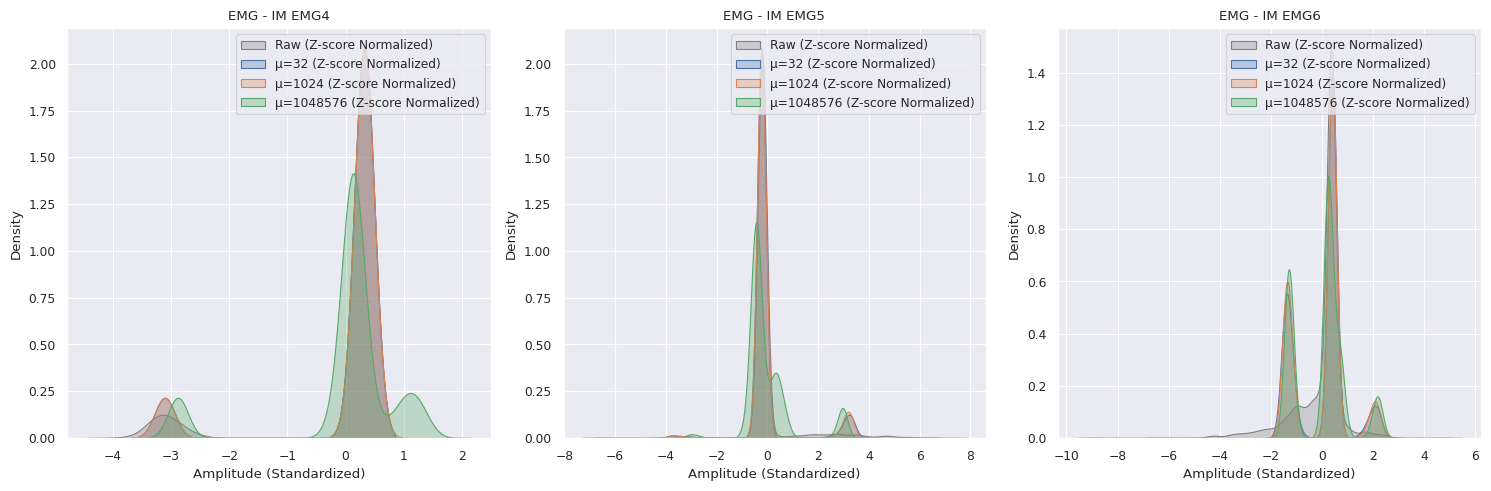

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def z_score_normalization(data):
    """Apply z-score normalization to standardize the data."""
    mean = np.mean(data, axis=(0, 1), keepdims=True)
    std = np.std(data, axis=(0, 1), keepdims=True)
    return (data - mean) / std

def plot_kde_comparison(data_list, raw_data, label, mu_values, channel_names=None):
    """Plot KDE for raw and μ-law normalized data."""
    channels = raw_data.shape[2]  # Get number of channels from the third axis (axis 2)

    # Standardize both raw and μ-law normalized data using z-score normalization
    raw_flat = z_score_normalization(raw_data).reshape(-1, channels)  # Standardize and flatten raw data
    data_flat = [z_score_normalization(data).reshape(-1, channels) for data in data_list]  # Standardize and flatten normalized data

    # Define grid size based on the number of channels (1 row for 3 channels)
    rows = (channels + 2) // 3  # Adjust number of rows based on the number of channels
    fig, axs = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    axs = axs.ravel()  # Flatten the axis array for easy indexing

    for i in range(channels):
        # Plot KDE for raw data with transparency
        sns.kdeplot(raw_flat[:, i], ax=axs[i], label='Raw (Z-score Normalized)', color='gray', fill=True, alpha=0.3)

        # Plot KDE for μ-law normalized data for different μ values with transparency
        for j, data in enumerate(data_flat):
            sns.kdeplot(data[:, i], ax=axs[i], label=f'μ={mu_values[j]} (Z-score Normalized)', fill=True, alpha=0.3)

        axs[i].set_title(f'{label} - {channel_names[i]}' if channel_names else f'{label} - Channel {i}')
        axs[i].set_xlabel('Amplitude (Standardized)')
        axs[i].set_ylabel('Density')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

def mu_law_normalization(x, mu=2**20):
    """Applies μ-law normalization to the input."""
    return np.sign(x) * np.log(1 + mu * np.abs(x)) / np.log(1 + mu)

# List to store normalized data for comparison
mu_values = [2**5,2**10,2**20]

# Normalize EMG data with different μ values
normalized_emg_list = [mu_law_normalization(emg.numpy(), mu=mu) for mu in mu_values]

# Plot KDE for raw and μ-law normalized EMG data across the entire dataset using z-score normalization
print("Plotting KDE for raw and normalized EMG data (Z-score normalized)...")
plot_kde_comparison(normalized_emg_list, emg.numpy(), label="EMG", mu_values=mu_values, channel_names=config.channels_emg)


In [ ]:
# @title Remake but with mu-noramlization
config.emg_transforms = [lambda x: mu_law_normalization(x, mu=mu) for mu in mu_values]

# Create datasets
train_dataset = ImuJointPairDataset(config, split='train')
test_dataset = ImuJointPairDataset(config, split='test')

# Setup validation dataset
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [int(0.9 * len(train_dataset)), len(train_dataset) - int(0.9 * len(train_dataset))])

# Setup dataloaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

acc,gyro,target,emg=next(iter(train_loader))
print(acc.shape)
print(gyro.shape)
print(target.shape)
print(emg.shape)

torch.Size([64, 100, 18])
torch.Size([64, 100, 18])
torch.Size([64, 100, 3])
torch.Size([64, 100, 3])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from scipy.signal import butter, filtfilt
from sklearn.metrics import mean_squared_error
import numpy as np
class Encoder_1(nn.Module):
    def __init__(self, input_dim, dropout):
        super(Encoder_1, self).__init__()
        self.lstm_1 = nn.LSTM(input_dim, 128, bidirectional=True, batch_first=True, dropout=0.0)
        self.lstm_2 = nn.LSTM(256, 64, bidirectional=True, batch_first=True, dropout=0.0)
        self.flatten=nn.Flatten()
        self.fc = nn.Linear(128, 32)
        self.dropout_1=nn.Dropout(dropout)
        self.dropout_2=nn.Dropout(dropout)


    def forward(self, x):
        out_1, _ = self.lstm_1(x)
        out_1=self.dropout_1(out_1)
        out_2, _ = self.lstm_2(out_1)
        out_2=self.dropout_2(out_2)

        return out_2




class Encoder_2(nn.Module):
    def __init__(self, input_dim, dropout):
        super(Encoder_2, self).__init__()
        self.lstm_1 = nn.GRU(input_dim, 128, bidirectional=True, batch_first=True, dropout=0.0)
        self.lstm_2 = nn.GRU(256, 64, bidirectional=True, batch_first=True, dropout=0.0)
        self.flatten=nn.Flatten()
        self.fc = nn.Linear(128, 32)
        self.dropout_1=nn.Dropout(dropout)
        self.dropout_2=nn.Dropout(dropout)


    def forward(self, x):
        out_1, _ = self.lstm_1(x)
        out_1=self.dropout_1(out_1)
        out_2, _ = self.lstm_2(out_1)
        out_2=self.dropout_2(out_2)

        return out_2


class GatingModule(nn.Module):
    def __init__(self, input_size):
        super(GatingModule, self).__init__()
        self.gate = nn.Sequential(
            nn.Linear(2*input_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, input1, input2):
        # Apply gating mechanism
        gate_output = self.gate(torch.cat((input1,input2),dim=-1))

        # Scale the inputs based on the gate output
        gated_input1 = input1 * gate_output
        gated_input2 = input2 * (1 - gate_output)

        # Combine the gated inputs
        output = gated_input1 + gated_input2
        return output
#variable w needs to be checked for correct value, stand-in value used
class teacher(nn.Module):
    def __init__(self, input_acc, input_gyr, input_emg, drop_prob=0.25, w=100):
        super(teacher, self).__init__()

        self.w=w
        self.encoder_1_acc=Encoder_1(input_acc, drop_prob)
        self.encoder_1_gyr=Encoder_1(input_gyr, drop_prob)
        self.encoder_1_emg=Encoder_1(input_emg, drop_prob)

        self.encoder_2_acc=Encoder_2(input_acc, drop_prob)
        self.encoder_2_gyr=Encoder_2(input_gyr, drop_prob)
        self.encoder_2_emg=Encoder_2(input_emg, drop_prob)

        self.BN_acc= nn.BatchNorm1d(input_acc, affine=False)
        self.BN_gyr= nn.BatchNorm1d(input_gyr, affine=False)
        self.BN_emg= nn.BatchNorm1d(input_emg, affine=False)


        self.fc = nn.Linear(2*3*128+128,3)
        self.dropout=nn.Dropout(p=0.05)

        self.gate_1=GatingModule(128)
        self.gate_2=GatingModule(128)
        self.gate_3=GatingModule(128)

        self.fc_kd = nn.Linear(3*128, 2*128)

               # Define the gating network
        self.weighted_feat = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid())

        self.attention=nn.MultiheadAttention(3*128,4,batch_first=True)
        self.gating_net = nn.Sequential(nn.Linear(128*3, 3*128), nn.Sigmoid())
        self.gating_net_1 = nn.Sequential(nn.Linear(2*3*128+128, 2*3*128+128), nn.Sigmoid())

        self.pool = nn.MaxPool1d(kernel_size=2)


    def forward(self, x_acc, x_gyr, x_emg):

        x_acc_1=x_acc.view(x_acc.size(0)*x_acc.size(1),x_acc.size(-1))
        x_gyr_1=x_gyr.view(x_gyr.size(0)*x_gyr.size(1),x_gyr.size(-1))
        x_emg_1=x_emg.view(x_emg.size(0)*x_emg.size(1),x_emg.size(-1))

        x_acc_1=self.BN_acc(x_acc_1)
        x_gyr_1=self.BN_gyr(x_gyr_1)
        x_emg_1=self.BN_emg(x_emg_1)

        x_acc_2=x_acc_1.view(-1, self.w, x_acc_1.size(-1))
        x_gyr_2=x_gyr_1.view(-1, self.w, x_gyr_1.size(-1))
        x_emg_2=x_emg_1.view(-1, self.w, x_emg_1.size(-1))

        x_acc_1=self.encoder_1_acc(x_acc_2)
        x_gyr_1=self.encoder_1_gyr(x_gyr_2)
        x_emg_1=self.encoder_1_emg(x_emg_2)

        x_acc_2=self.encoder_2_acc(x_acc_2)
        x_gyr_2=self.encoder_2_gyr(x_gyr_2)
        x_emg_2=self.encoder_2_emg(x_emg_2)

        # x_acc=torch.cat((x_acc_1,x_acc_2),dim=-1)
        # x_gyr=torch.cat((x_gyr_1,x_gyr_2),dim=-1)
        # x_emg=torch.cat((x_emg_1,x_emg_2),dim=-1)

        x_acc=self.gate_1(x_acc_1,x_acc_2)
        x_gyr=self.gate_2(x_gyr_1,x_gyr_2)
        x_emg=self.gate_3(x_emg_1,x_emg_2)

        x=torch.cat((x_acc,x_gyr,x_emg),dim=-1)
        x_kd=self.fc_kd(x)


        out_1, attn_output_weights=self.attention(x,x,x)

        gating_weights = self.gating_net(x)
        out_2=gating_weights*x

        weights_1 = self.weighted_feat(x[:,:,0:128])
        weights_2 = self.weighted_feat(x[:,:,128:2*128])
        weights_3 = self.weighted_feat(x[:,:,2*128:3*128])
        x_1=weights_1*x[:,:,0:128]
        x_2=weights_2*x[:,:,128:2*128]
        x_3=weights_3*x[:,:,2*128:3*128]
        out_3=x_1+x_2+x_3

        out=torch.cat((out_1,out_2,out_3),dim=-1)

        gating_weights_1 = self.gating_net_1(out)
        out=gating_weights_1*out

        out=self.fc(out)

        #print(out.shape)
        return out,x_kd


class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
    def forward(self, output, target):
        loss = torch.sqrt(torch.mean((output - target) ** 2))
        return loss
#prediction function
def RMSE_prediction(yhat_4,test_y, output_dim,print_losses=True):

  s1=yhat_4.shape[0]*yhat_4.shape[1]

  test_o=test_y.reshape((s1,output_dim))
  yhat=yhat_4.reshape((s1,output_dim))




  y_1_no=yhat[:,0]
  y_2_no=yhat[:,1]
  y_3_no=yhat[:,2]

  y_1=y_1_no
  y_2=y_2_no
  y_3=y_3_no


  y_test_1=test_o[:,0]
  y_test_2=test_o[:,1]
  y_test_3=test_o[:,2]



  cutoff=6
  fs=200
  order=4

  nyq = 0.5 * fs
  ## filtering data ##
  def butter_lowpass_filter(data, cutoff, fs, order):
      normal_cutoff = cutoff / nyq
      # Get the filter coefficients
      b, a = butter(order, normal_cutoff, btype='low', analog=False)
      y = filtfilt(b, a, data)
      return y



  Z_1=y_1
  Z_2=y_2
  Z_3=y_3



  ###calculate RMSE

  rmse_1 =((np.sqrt(mean_squared_error(y_test_1,y_1))))
  rmse_2 =((np.sqrt(mean_squared_error(y_test_2,y_2))))
  rmse_3 =((np.sqrt(mean_squared_error(y_test_3,y_3))))





  p_1=np.corrcoef(y_1, y_test_1)[0, 1]
  p_2=np.corrcoef(y_2, y_test_2)[0, 1]
  p_3=np.corrcoef(y_3, y_test_3)[0, 1]




              ### Correlation ###
  p=np.array([p_1,p_2,p_3])
  #,p_4,p_5,p_6,p_7])




      #### Mean and standard deviation ####

  rmse=np.array([rmse_1,rmse_2,rmse_3])
  #,rmse_4,rmse_5,rmse_6,rmse_7])

      #### Mean and standard deviation ####
  m=statistics.mean(rmse)
  SD=statistics.stdev(rmse)


  m_c=statistics.mean(p)
  SD_c=statistics.stdev(p)


  if print_losses:
    print(rmse_1)
    print(rmse_2)
    print(rmse_3)
    print("\n")
    print(p_1)
    print(p_2)
    print(p_3)
    print('Mean: %.3f' % m,'+/- %.3f' %SD)
    print('Mean: %.3f' % m_c,'+/- %.3f' %SD_c)

  return rmse, p, Z_1,Z_2,Z_3
  #,Z_4,Z_5,Z_6,Z_7



############################################################################################################################################################################################################################################################################################################################################################################################################################################################################




In [ ]:
import torch
import numpy as np
import os
import time
from tqdm.notebook import tqdm

import statistics

# Define the GHM-MSE Loss
class GHMMSELoss(torch.nn.Module):
    def __init__(self, bins=10, momentum=0.75):
        super(GHMMSELoss, self).__init__()
        self.bins = bins
        self.momentum = momentum
        self.edges = torch.linspace(0, 1, bins + 1)  # Initially on CPU
        self.acc_sum = torch.zeros(bins)  # Initially on CPU

    def forward(self, input, target):
        device = input.device  # Ensure we use the same device as input tensor
        self.edges = self.edges.to(device)  # Move edges to the same device
        self.acc_sum = self.acc_sum.to(device)  # Move acc_sum to the same device

        # Calculate the gradient norm (g)
        g = torch.sigmoid(2 * (input - target))
        g = g.detach()

        # Compute the gradient density
        n = input.size(0)
        inds = torch.bucketize(g, self.edges)
        total = torch.zeros_like(self.acc_sum)

        # Counting in each bin and calculate gradient harmonizing parameter (beta)
        for i in range(self.bins):
            total[i] = (inds == i + 1).float().sum()

        if self.training:
            self.acc_sum = self.momentum * self.acc_sum + (1 - self.momentum) * total
        acc_sum = self.acc_sum.clone().detach()

        # Beta calculation based on GD
        beta = torch.zeros_like(inds, dtype=torch.float32)
        for i in range(self.bins):
            beta[inds == i + 1] = n / (acc_sum[i] + 1e-6)

        loss = (beta * (input - target) ** 2).mean()
        return loss


# Define OHEM-MSE Loss
class OHEMMSELoss(torch.nn.Module):
    def __init__(self, ratio=0.7):
        super(OHEMMSELoss, self).__init__()
        self.ratio = ratio
        self.mse_loss = torch.nn.MSELoss(reduction='none')

    def forward(self, input, target):
        losses = self.mse_loss(input, target)
        num_hard_examples = int(self.ratio * losses.numel())
        hard_losses, _ = torch.topk(losses.view(-1), num_hard_examples)
        return hard_losses.mean()

# Evaluation function
def evaluate_model(device, model, loader, criterion):
    """Runs evaluation on the validation or test set."""
    model.eval()
    total_loss = 0.0
    total_pcc = np.zeros(len(config.channels_joints))
    total_rmse = np.zeros(len(config.channels_joints))

    with torch.no_grad():
        for i, (data_acc, data_gyr, target, data_EMG) in enumerate(loader):
            output, _ = model(data_acc.to(device).float(), data_gyr.to(device).float(), data_EMG.to(device).float())
            loss = criterion(output, target.to(device).float())
            batch_rmse, batch_pcc, _, _, _ = RMSE_prediction(output.detach().cpu().numpy(), target.detach().cpu().numpy(), len(config.channels_joints), print_losses=False)
            total_loss += loss.item()
            total_pcc += batch_pcc
            total_rmse += batch_rmse

    avg_loss = total_loss / len(loader)
    avg_pcc = total_pcc / len(loader)
    avg_rmse = total_rmse / len(loader)

    return avg_loss, avg_pcc, avg_rmse

# Save checkpoint function
def save_checkpoint(model, optimizer, epoch, filename, train_loss, val_loss, test_loss=None, channelwise_metrics=None):
    """Saves the model, optimizer state, and losses (including channel-wise) to a checkpoint."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_channelwise_metrics': channelwise_metrics['train'],
        'val_channelwise_metrics': channelwise_metrics['val'],
    }
    if test_loss is not None:
        checkpoint['test_loss'] = test_loss
        checkpoint['test_channelwise_metrics'] = channelwise_metrics['test']
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved for epoch {epoch + 1}")

# Training function
def train_teacher(device, train_loader, val_loader, test_loader, learn_rate, epochs, model, filename,loss_function):

    model.to(device)
    criterion = loss_function
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    train_losses = []
    val_losses = []
    test_losses = []

    train_pccs = []
    val_pccs = []
    test_pccs = []

    train_rmses = []
    val_rmses = []
    test_rmses = []

    start_time = time.time()
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()

        epoch_train_loss = np.zeros(len(config.channels_joints))
        epoch_train_pcc = np.zeros(len(config.channels_joints))
        epoch_train_rmse = np.zeros(len(config.channels_joints))

        for i, (data_acc, data_gyr, target, data_EMG) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} Training")):
            optimizer.zero_grad()
            output, _ = model(data_acc.to(device).float(), data_gyr.to(device).float(), data_EMG.to(device).float())
            loss = criterion(output, target.to(device).float())
            loss.backward()
            optimizer.step()

            batch_rmse, batch_pcc, _, _, _ = RMSE_prediction(output.detach().cpu().numpy(), target.detach().cpu().numpy(), len(config.channels_joints), print_losses=False)
            epoch_train_loss += loss.detach().cpu().numpy()
            epoch_train_pcc += batch_pcc
            epoch_train_rmse += batch_rmse

        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_train_pcc = epoch_train_pcc / len(train_loader)
        avg_train_rmse = epoch_train_rmse / len(train_loader)

        train_losses.append(avg_train_loss)
        train_pccs.append(avg_train_pcc)
        train_rmses.append(avg_train_rmse)

        # Evaluate on validation set every epoch
        avg_val_loss, avg_val_pcc, avg_val_rmse = evaluate_model(device, model, val_loader, criterion)
        val_losses.append(avg_val_loss)
        val_pccs.append(avg_val_pcc)
        val_rmses.append(avg_val_rmse)

        # Evaluate on test set and checkpoint every epoch
        avg_test_loss, avg_test_pcc, avg_test_rmse = evaluate_model(device, model, test_loader, criterion)
        test_losses.append(avg_test_loss)
        test_pccs.append(avg_test_pcc)
        test_rmses.append(avg_test_rmse)

        print(f"Epoch: {epoch + 1}, Training Loss: {np.mean(avg_train_loss)}, Validation Loss: {np.mean(avg_val_loss):.4f}", f"Test Loss: {np.mean(avg_test_loss):.4f}")
        print(f"Training RMSE: {np.mean(avg_train_rmse)}, Validation RMSE: {np.mean(avg_val_rmse):.4f}", f"Test RMSE: {np.mean(avg_test_rmse):.4f}")
        print(f"Training PCC: {np.mean(avg_train_pcc)}, Validation PCC: {np.mean(avg_val_pcc):.4f}", f"Test PCC: {np.mean(avg_test_pcc):.4f}")

        if not os.path.exists(f"/content/MyDrive/MyDrive/models/{filename}"):
            os.makedirs(f"/content/MyDrive/MyDrive/models/{filename}")

        # Save checkpoint, including channel-wise metrics
        save_checkpoint(
            model,
            optimizer,
            epoch,
            f"/content/MyDrive/MyDrive/models/{filename}/{filename}_epoch_{epoch+1}.pth",
            train_loss=avg_train_loss,
            val_loss=avg_val_loss,
            test_loss=avg_test_loss,
            channelwise_metrics={
                'train': {'pcc': avg_train_pcc, 'rmse': avg_train_rmse},
                'val': {'pcc': avg_val_pcc, 'rmse': avg_val_rmse},
                'test': {'pcc': avg_test_pcc, 'rmse': avg_test_rmse},
            }
        )

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), filename)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Stopping early after {epoch + 1} epochs")
            break

    end_time = time.time()
    print(f"Total training time: {end_time - start_time:.2f} seconds")

    return model, train_losses, val_losses, test_losses, train_pccs, val_pccs, test_pccs, train_rmses, val_rmses, test_rmses



# Dictionary of models and their corresponding loss functions
model_configs = {
    'GHMMSELoss': {
        'model': teacher(
                      input_acc=len(config.channels_imu_acc),
                      input_gyr=len(config.channels_imu_gyr),
                      input_emg=len(config.channels_emg)
                  ),
        'loss': GHMMSELoss()  # Use GHM-MSE Loss for this model
    },
    'OHEMMSELoss': {
        'model': teacher(
                      input_acc=len(config.channels_imu_acc),
                      input_gyr=len(config.channels_imu_gyr),
                      input_emg=len(config.channels_emg)
                  ),
        'loss': OHEMMSELoss()  # Use OHEM-MSE Loss for this model
    },
}

config.epochs = 100
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loop over each model and run the training with the corresponding loss function
for model_name, model_config in model_configs.items():
    model = model_config['model']
    loss_function = model_config['loss']  # Get the corresponding loss function

    print(f"Starting training for {model_name} using {loss_function.__class__.__name__}...")

    # Train the model using the common loaders, learning rate, and epochs from config
    model, train_losses, val_losses, test_losses, train_pccs, val_pccs, test_pccs, train_rmses, val_rmses, test_rmses = train_teacher(
        device,
        train_loader,
        val_loader,
        test_loader,
        config.lr,  # Learning rate from config
        config.epochs,  # Epochs from config
        model,
        model_name,  # Save checkpoint file named after the model
        loss_function  # Pass the specific loss function
    )

    print(f"Finished training for {model_name}.")


Starting training for GHMMSELoss using GHMMSELoss...


Epoch 1/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 2.220645417799228, Validation Loss: 1.2512 Test Loss: 3.0214
Training RMSE: 29.430058005773464, Validation RMSE: 16.0902 Test RMSE: 21.2997
Training PCC: 0.6103805171115169, Validation PCC: 0.8831 Test PCC: 0.6135
Checkpoint saved for epoch 1


Epoch 2/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.9712501645795669, Validation Loss: 0.7094 Test Loss: 2.4863
Training RMSE: 12.579861240971807, Validation RMSE: 10.3363 Test RMSE: 16.9752
Training PCC: 0.9269526260527129, Validation PCC: 0.9557 Test PCC: 0.6521
Checkpoint saved for epoch 2


Epoch 3/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.6998098700442724, Validation Loss: 0.4874 Test Loss: 2.2426
Training RMSE: 10.340959855993708, Validation RMSE: 8.7722 Test RMSE: 16.8230
Training PCC: 0.9513579621304565, Validation PCC: 0.9662 Test PCC: 0.6677
Checkpoint saved for epoch 3


Epoch 4/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.5841378345864463, Validation Loss: 0.4631 Test Loss: 2.4634
Training RMSE: 9.498436493406663, Validation RMSE: 7.9552 Test RMSE: 18.1222
Training PCC: 0.9593562818058952, Validation PCC: 0.9696 Test PCC: 0.6474
Checkpoint saved for epoch 4


Epoch 5/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.5292135890053712, Validation Loss: 0.4308 Test Loss: 2.3287
Training RMSE: 9.067964429789315, Validation RMSE: 9.2196 Test RMSE: 17.0448
Training PCC: 0.9634377807782689, Validation PCC: 0.9634 Test PCC: 0.6502
Checkpoint saved for epoch 5


Epoch 6/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 0.496765071454317, Validation Loss: 0.3549 Test Loss: 2.2033
Training RMSE: 8.969174815214705, Validation RMSE: 7.2759 Test RMSE: 16.9735
Training PCC: 0.9642060530701309, Validation PCC: 0.9761 Test PCC: 0.6546
Checkpoint saved for epoch 6


Epoch 7/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 0.4342011116025002, Validation Loss: 0.3072 Test Loss: 2.7064
Training RMSE: 8.261662222393424, Validation RMSE: 7.1438 Test RMSE: 18.4755
Training PCC: 0.9693342211548622, Validation PCC: 0.9769 Test PCC: 0.6394
Checkpoint saved for epoch 7


Epoch 8/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 0.41554539882818387, Validation Loss: 0.3073 Test Loss: 2.7595
Training RMSE: 8.180577246536723, Validation RMSE: 7.1038 Test RMSE: 17.7899
Training PCC: 0.9701099008238181, Validation PCC: 0.9777 Test PCC: 0.6783
Checkpoint saved for epoch 8


Epoch 9/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 9, Training Loss: 0.3917283081955301, Validation Loss: 0.3611 Test Loss: 2.1355
Training RMSE: 7.998673628628786, Validation RMSE: 7.6292 Test RMSE: 17.4003
Training PCC: 0.9712768608011291, Validation PCC: 0.9744 Test PCC: 0.6327
Checkpoint saved for epoch 9


Epoch 10/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 10, Training Loss: 0.40294120812274575, Validation Loss: 0.2886 Test Loss: 2.2228
Training RMSE: 8.135942606496764, Validation RMSE: 6.8317 Test RMSE: 18.1231
Training PCC: 0.9705955243815728, Validation PCC: 0.9808 Test PCC: 0.6234
Checkpoint saved for epoch 10


Epoch 11/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 11, Training Loss: 0.3573006739955981, Validation Loss: 0.2828 Test Loss: 2.4531
Training RMSE: 7.611021401030846, Validation RMSE: 6.6382 Test RMSE: 18.0103
Training PCC: 0.9745459447129705, Validation PCC: 0.9812 Test PCC: 0.6519
Checkpoint saved for epoch 11


Epoch 12/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 12, Training Loss: 0.3629605912490132, Validation Loss: 0.2644 Test Loss: 2.2694
Training RMSE: 7.7600622441247475, Validation RMSE: 6.5306 Test RMSE: 17.6606
Training PCC: 0.9726216725951075, Validation PCC: 0.9801 Test PCC: 0.6333
Checkpoint saved for epoch 12


Epoch 13/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 13, Training Loss: 0.3395903886514177, Validation Loss: 0.2609 Test Loss: 2.1117
Training RMSE: 7.442357415851099, Validation RMSE: 7.1473 Test RMSE: 16.5434
Training PCC: 0.97504843858067, Validation PCC: 0.9760 Test PCC: 0.6498
Checkpoint saved for epoch 13


Epoch 14/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 14, Training Loss: 0.32064847882494374, Validation Loss: 0.2701 Test Loss: 2.2395
Training RMSE: 7.093100554393614, Validation RMSE: 6.0536 Test RMSE: 17.6299
Training PCC: 0.9776304767053562, Validation PCC: 0.9825 Test PCC: 0.6418
Checkpoint saved for epoch 14


Epoch 15/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 15, Training Loss: 0.29790854277172146, Validation Loss: 0.2287 Test Loss: 2.4737
Training RMSE: 6.8081192307609015, Validation RMSE: 6.2124 Test RMSE: 18.1378
Training PCC: 0.979287871716649, Validation PCC: 0.9822 Test PCC: 0.6424
Checkpoint saved for epoch 15


Epoch 16/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 16, Training Loss: 0.28729058992261347, Validation Loss: 0.2349 Test Loss: 2.2436
Training RMSE: 6.603297898135011, Validation RMSE: 5.9286 Test RMSE: 17.4750
Training PCC: 0.9802114568431479, Validation PCC: 0.9846 Test PCC: 0.6490
Checkpoint saved for epoch 16


Epoch 17/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 17, Training Loss: 0.2791679970234721, Validation Loss: 0.2152 Test Loss: 2.1046
Training RMSE: 6.584492631293428, Validation RMSE: 5.6171 Test RMSE: 17.1818
Training PCC: 0.980265331813619, Validation PCC: 0.9861 Test PCC: 0.6752
Checkpoint saved for epoch 17


Epoch 18/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 18, Training Loss: 0.29306764109198347, Validation Loss: 0.2560 Test Loss: 2.2018
Training RMSE: 6.834014788815341, Validation RMSE: 6.2850 Test RMSE: 17.5941
Training PCC: 0.9786862905743007, Validation PCC: 0.9827 Test PCC: 0.6588
Checkpoint saved for epoch 18


Epoch 19/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 19, Training Loss: 0.2626666688423836, Validation Loss: 0.2079 Test Loss: 2.3597
Training RMSE: 6.298990420134909, Validation RMSE: 5.6049 Test RMSE: 18.1179
Training PCC: 0.9822333975551385, Validation PCC: 0.9858 Test PCC: 0.6475
Checkpoint saved for epoch 19


Epoch 20/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 20, Training Loss: 0.27842818616228926, Validation Loss: 0.2568 Test Loss: 2.9509
Training RMSE: 6.623164783717381, Validation RMSE: 6.3736 Test RMSE: 18.8363
Training PCC: 0.9798344170565656, Validation PCC: 0.9814 Test PCC: 0.6338
Checkpoint saved for epoch 20


Epoch 21/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 21, Training Loss: 0.26545847443869275, Validation Loss: 0.2052 Test Loss: 2.4520
Training RMSE: 6.337167104321111, Validation RMSE: 5.4768 Test RMSE: 18.0802
Training PCC: 0.9818822335966167, Validation PCC: 0.9865 Test PCC: 0.6476
Checkpoint saved for epoch 21


Epoch 22/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 22, Training Loss: 0.2393059165877475, Validation Loss: 0.1967 Test Loss: 2.4769
Training RMSE: 5.965852282285454, Validation RMSE: 5.4259 Test RMSE: 17.5785
Training PCC: 0.9839865868055676, Validation PCC: 0.9865 Test PCC: 0.6470
Checkpoint saved for epoch 22


Epoch 23/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 23, Training Loss: 0.2285716869268644, Validation Loss: 0.1834 Test Loss: 2.4524
Training RMSE: 5.837386249198876, Validation RMSE: 5.2161 Test RMSE: 17.6261
Training PCC: 0.9847476360122179, Validation PCC: 0.9874 Test PCC: 0.6553
Checkpoint saved for epoch 23


Epoch 24/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 24, Training Loss: 0.21682638230592632, Validation Loss: 0.2294 Test Loss: 2.7036
Training RMSE: 5.690715383705116, Validation RMSE: 6.4133 Test RMSE: 18.4974
Training PCC: 0.9854289395113026, Validation PCC: 0.9811 Test PCC: 0.6459
Checkpoint saved for epoch 24


Epoch 25/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 25, Training Loss: 0.2213777378864741, Validation Loss: 0.1842 Test Loss: 2.3684
Training RMSE: 5.743755760107974, Validation RMSE: 5.2751 Test RMSE: 17.2191
Training PCC: 0.98534936959071, Validation PCC: 0.9873 Test PCC: 0.6611
Checkpoint saved for epoch 25


Epoch 26/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 26, Training Loss: 0.21402045876583642, Validation Loss: 0.1837 Test Loss: 2.6120
Training RMSE: 5.676235066912883, Validation RMSE: 5.0293 Test RMSE: 18.4338
Training PCC: 0.9855688848125728, Validation PCC: 0.9888 Test PCC: 0.6374
Checkpoint saved for epoch 26


Epoch 27/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 27, Training Loss: 0.20742793905186727, Validation Loss: 0.1762 Test Loss: 2.0502
Training RMSE: 5.523451721868695, Validation RMSE: 4.9164 Test RMSE: 16.2683
Training PCC: 0.9864118256032531, Validation PCC: 0.9895 Test PCC: 0.6965
Checkpoint saved for epoch 27


Epoch 28/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 28, Training Loss: 0.1992575438687639, Validation Loss: 0.1682 Test Loss: 2.0501
Training RMSE: 5.448678967742844, Validation RMSE: 4.9112 Test RMSE: 16.5142
Training PCC: 0.9866905039351103, Validation PCC: 0.9884 Test PCC: 0.6654
Checkpoint saved for epoch 28


Epoch 29/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 29, Training Loss: 0.1927693501247497, Validation Loss: 0.1862 Test Loss: 2.3058
Training RMSE: 5.296604794635264, Validation RMSE: 4.7822 Test RMSE: 17.4009
Training PCC: 0.9873628058004238, Validation PCC: 0.9888 Test PCC: 0.6524
Checkpoint saved for epoch 29


Epoch 30/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 30, Training Loss: 0.2012290894012423, Validation Loss: 0.1730 Test Loss: 2.6568
Training RMSE: 5.465284478888432, Validation RMSE: 4.8268 Test RMSE: 17.8360
Training PCC: 0.9864220440288655, Validation PCC: 0.9887 Test PCC: 0.6492
Checkpoint saved for epoch 30


Epoch 31/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 31, Training Loss: 0.20957120320032896, Validation Loss: 0.2294 Test Loss: 2.2857
Training RMSE: 5.601141483210668, Validation RMSE: 5.2738 Test RMSE: 17.4392
Training PCC: 0.9856026702602513, Validation PCC: 0.9864 Test PCC: 0.6682
Checkpoint saved for epoch 31


Epoch 32/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 32, Training Loss: 0.2160983900995566, Validation Loss: 0.1927 Test Loss: 2.6292
Training RMSE: 5.6356512094699545, Validation RMSE: 5.2504 Test RMSE: 17.8131
Training PCC: 0.985429641584381, Validation PCC: 0.9871 Test PCC: 0.6289
Checkpoint saved for epoch 32


Epoch 33/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 33, Training Loss: 0.1934343769217811, Validation Loss: 0.1829 Test Loss: 2.2465
Training RMSE: 5.257944560074547, Validation RMSE: 4.7311 Test RMSE: 17.0042
Training PCC: 0.987480537150628, Validation PCC: 0.9901 Test PCC: 0.6784
Checkpoint saved for epoch 33


Epoch 34/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 34, Training Loss: 0.18463982926897196, Validation Loss: 0.1596 Test Loss: 2.1890
Training RMSE: 5.157711407079423, Validation RMSE: 4.6347 Test RMSE: 16.6754
Training PCC: 0.9880752355593655, Validation PCC: 0.9901 Test PCC: 0.6679
Checkpoint saved for epoch 34


Epoch 35/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 35, Training Loss: 0.16934772366409132, Validation Loss: 0.1540 Test Loss: 2.0408
Training RMSE: 4.925336913939871, Validation RMSE: 4.5418 Test RMSE: 17.2624
Training PCC: 0.9889642889368288, Validation PCC: 0.9912 Test PCC: 0.6610
Checkpoint saved for epoch 35


Epoch 36/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 36, Training Loss: 0.17512635922042832, Validation Loss: 0.1562 Test Loss: 2.1708
Training RMSE: 4.967456056385436, Validation RMSE: 4.5106 Test RMSE: 17.1052
Training PCC: 0.9886735965574321, Validation PCC: 0.9907 Test PCC: 0.6454
Checkpoint saved for epoch 36


Epoch 37/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 37, Training Loss: 0.1710117114846006, Validation Loss: 0.1498 Test Loss: 2.3146
Training RMSE: 4.925250501708155, Validation RMSE: 4.3705 Test RMSE: 17.0961
Training PCC: 0.9889829782360823, Validation PCC: 0.9910 Test PCC: 0.6605
Checkpoint saved for epoch 37


Epoch 38/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 38, Training Loss: 0.16272288481276537, Validation Loss: 0.1405 Test Loss: 2.2825
Training RMSE: 4.804319279601855, Validation RMSE: 4.2691 Test RMSE: 17.2596
Training PCC: 0.989442714067056, Validation PCC: 0.9914 Test PCC: 0.6614
Checkpoint saved for epoch 38


Epoch 39/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 39, Training Loss: 0.16428724484026255, Validation Loss: 0.1449 Test Loss: 2.2152
Training RMSE: 4.791084320443791, Validation RMSE: 4.3433 Test RMSE: 17.4691
Training PCC: 0.9895389947310033, Validation PCC: 0.9914 Test PCC: 0.6437
Checkpoint saved for epoch 39


Epoch 40/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 40, Training Loss: 0.1570373300451907, Validation Loss: 0.1421 Test Loss: 2.0082
Training RMSE: 4.690189276203793, Validation RMSE: 4.3436 Test RMSE: 16.5850
Training PCC: 0.9898309054634735, Validation PCC: 0.9911 Test PCC: 0.6841
Checkpoint saved for epoch 40


Epoch 41/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 41, Training Loss: 0.15274560650484498, Validation Loss: 0.1477 Test Loss: 2.2826
Training RMSE: 4.613177608665443, Validation RMSE: 4.4542 Test RMSE: 17.4942
Training PCC: 0.9902916178980071, Validation PCC: 0.9915 Test PCC: 0.6622
Checkpoint saved for epoch 41


Epoch 42/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 42, Training Loss: 0.14988095916873978, Validation Loss: 0.1432 Test Loss: 2.0930
Training RMSE: 4.552380469149581, Validation RMSE: 4.3738 Test RMSE: 16.8992
Training PCC: 0.9903088620590724, Validation PCC: 0.9918 Test PCC: 0.6593
Checkpoint saved for epoch 42


Epoch 43/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 43, Training Loss: 0.15236806772229225, Validation Loss: 0.1480 Test Loss: 2.2775
Training RMSE: 4.578707645720002, Validation RMSE: 4.4548 Test RMSE: 16.5240
Training PCC: 0.9904725569752745, Validation PCC: 0.9910 Test PCC: 0.6673
Checkpoint saved for epoch 43


Epoch 44/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 44, Training Loss: 0.14560886222637018, Validation Loss: 0.1426 Test Loss: 2.2873
Training RMSE: 4.468277090263178, Validation RMSE: 4.3302 Test RMSE: 17.0171
Training PCC: 0.9906467477586117, Validation PCC: 0.9918 Test PCC: 0.6823
Checkpoint saved for epoch 44


Epoch 45/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 45, Training Loss: 0.14711640403780102, Validation Loss: 0.1234 Test Loss: 2.2544
Training RMSE: 4.504672994009937, Validation RMSE: 4.0138 Test RMSE: 16.5891
Training PCC: 0.9904799472674951, Validation PCC: 0.9924 Test PCC: 0.6738
Checkpoint saved for epoch 45


Epoch 46/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 46, Training Loss: 0.1392006470161305, Validation Loss: 0.1440 Test Loss: 2.2996
Training RMSE: 4.371127716039927, Validation RMSE: 4.4129 Test RMSE: 16.7700
Training PCC: 0.9910232999329995, Validation PCC: 0.9921 Test PCC: 0.6852
Checkpoint saved for epoch 46


Epoch 47/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 47, Training Loss: 0.14281745442916094, Validation Loss: 0.1360 Test Loss: 2.2644
Training RMSE: 4.442159048999216, Validation RMSE: 4.2837 Test RMSE: 16.6453
Training PCC: 0.9907468936714969, Validation PCC: 0.9919 Test PCC: 0.6853
Checkpoint saved for epoch 47


Epoch 48/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 48, Training Loss: 0.13907435792843736, Validation Loss: 0.1381 Test Loss: 2.4832
Training RMSE: 4.381725984086622, Validation RMSE: 4.2650 Test RMSE: 17.3289
Training PCC: 0.9908323240469739, Validation PCC: 0.9922 Test PCC: 0.6573
Checkpoint saved for epoch 48


Epoch 49/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 49, Training Loss: 0.13778014571712704, Validation Loss: 0.1430 Test Loss: 2.2768
Training RMSE: 4.363024885647374, Validation RMSE: 4.2870 Test RMSE: 17.4071
Training PCC: 0.9910865063236249, Validation PCC: 0.9922 Test PCC: 0.6654
Checkpoint saved for epoch 49


Epoch 50/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 50, Training Loss: 0.13902051076956248, Validation Loss: 0.1261 Test Loss: 2.2726
Training RMSE: 4.37961458004311, Validation RMSE: 4.0089 Test RMSE: 17.0901
Training PCC: 0.9910603269291917, Validation PCC: 0.9923 Test PCC: 0.6693
Checkpoint saved for epoch 50


Epoch 51/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 51, Training Loss: 0.13849886438259384, Validation Loss: 0.1263 Test Loss: 2.0845
Training RMSE: 4.355654001000137, Validation RMSE: 4.0464 Test RMSE: 16.6922
Training PCC: 0.9910418195668429, Validation PCC: 0.9925 Test PCC: 0.6756
Checkpoint saved for epoch 51


Epoch 52/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 52, Training Loss: 0.12954002172197007, Validation Loss: 0.1240 Test Loss: 2.2562
Training RMSE: 4.208252040615893, Validation RMSE: 4.0482 Test RMSE: 16.9064
Training PCC: 0.9915122753216735, Validation PCC: 0.9927 Test PCC: 0.6666
Checkpoint saved for epoch 52


Epoch 53/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 53, Training Loss: 0.1249161711078723, Validation Loss: 0.1367 Test Loss: 2.1741
Training RMSE: 4.1330176802936105, Validation RMSE: 4.2912 Test RMSE: 16.8626
Training PCC: 0.9918777030143738, Validation PCC: 0.9927 Test PCC: 0.6580
Checkpoint saved for epoch 53


Epoch 54/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 54, Training Loss: 0.1275416936073176, Validation Loss: 0.1175 Test Loss: 2.2127
Training RMSE: 4.187863859059667, Validation RMSE: 3.8965 Test RMSE: 16.6530
Training PCC: 0.9916901822556512, Validation PCC: 0.9932 Test PCC: 0.6797
Checkpoint saved for epoch 54


Epoch 55/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 55, Training Loss: 0.12195658201810515, Validation Loss: 0.1234 Test Loss: 2.1282
Training RMSE: 4.099826186865893, Validation RMSE: 3.9610 Test RMSE: 15.9634
Training PCC: 0.9919978279257426, Validation PCC: 0.9932 Test PCC: 0.6866
Checkpoint saved for epoch 55


Epoch 56/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 56, Training Loss: 0.11920335818115257, Validation Loss: 0.1243 Test Loss: 2.3037
Training RMSE: 4.0263436833427875, Validation RMSE: 4.0171 Test RMSE: 16.9123
Training PCC: 0.9923231908134104, Validation PCC: 0.9930 Test PCC: 0.6740
Checkpoint saved for epoch 56


Epoch 57/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 57, Training Loss: 0.12044456161182783, Validation Loss: 0.1249 Test Loss: 2.0561
Training RMSE: 4.032000393353395, Validation RMSE: 3.9710 Test RMSE: 15.9088
Training PCC: 0.9922801733853889, Validation PCC: 0.9931 Test PCC: 0.6879
Checkpoint saved for epoch 57


Epoch 58/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 58, Training Loss: 0.11882598527903372, Validation Loss: 0.1304 Test Loss: 2.1476
Training RMSE: 3.989822769023545, Validation RMSE: 4.1721 Test RMSE: 16.2194
Training PCC: 0.9923909276886339, Validation PCC: 0.9928 Test PCC: 0.6763
Checkpoint saved for epoch 58


Epoch 59/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 59, Training Loss: 0.11668101841865731, Validation Loss: 0.1207 Test Loss: 1.9844
Training RMSE: 3.9785521983157044, Validation RMSE: 3.9887 Test RMSE: 15.6781
Training PCC: 0.992378968361518, Validation PCC: 0.9933 Test PCC: 0.7099
Checkpoint saved for epoch 59


Epoch 60/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 60, Training Loss: 0.11549675519901496, Validation Loss: 0.1285 Test Loss: 2.3035
Training RMSE: 3.949418320264354, Validation RMSE: 4.1801 Test RMSE: 17.1344
Training PCC: 0.9925040902406246, Validation PCC: 0.9930 Test PCC: 0.6708
Checkpoint saved for epoch 60


Epoch 61/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 61, Training Loss: 0.11723585148239701, Validation Loss: 0.1155 Test Loss: 2.1167
Training RMSE: 3.987455352713399, Validation RMSE: 3.8424 Test RMSE: 15.9549
Training PCC: 0.9924218261601747, Validation PCC: 0.9934 Test PCC: 0.6909
Checkpoint saved for epoch 61


Epoch 62/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 62, Training Loss: 0.11411927549793034, Validation Loss: 0.1317 Test Loss: 2.0618
Training RMSE: 3.9074369080578424, Validation RMSE: 4.0082 Test RMSE: 16.0119
Training PCC: 0.9926935470818136, Validation PCC: 0.9933 Test PCC: 0.6889
Checkpoint saved for epoch 62


Epoch 63/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 63, Training Loss: 0.11146097199145694, Validation Loss: 0.1151 Test Loss: 2.1228
Training RMSE: 3.8694343762628876, Validation RMSE: 3.9038 Test RMSE: 15.7529
Training PCC: 0.9927275407425573, Validation PCC: 0.9930 Test PCC: 0.6963
Checkpoint saved for epoch 63


Epoch 64/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 64, Training Loss: 0.11348215621020037, Validation Loss: 0.1332 Test Loss: 2.0616
Training RMSE: 3.9062000549629583, Validation RMSE: 4.0389 Test RMSE: 15.9491
Training PCC: 0.9925867528491015, Validation PCC: 0.9928 Test PCC: 0.6776
Checkpoint saved for epoch 64


Epoch 65/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 65, Training Loss: 0.15499298091016112, Validation Loss: 0.1490 Test Loss: 2.1900
Training RMSE: 4.6306555525839155, Validation RMSE: 4.4618 Test RMSE: 16.8805
Training PCC: 0.9892954800490101, Validation PCC: 0.9913 Test PCC: 0.6686
Checkpoint saved for epoch 65


Epoch 66/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 66, Training Loss: 0.13278730770777525, Validation Loss: 0.1155 Test Loss: 2.4233
Training RMSE: 4.255459225142391, Validation RMSE: 3.7754 Test RMSE: 16.6447
Training PCC: 0.9911990842190955, Validation PCC: 0.9936 Test PCC: 0.6835
Checkpoint saved for epoch 66


Epoch 67/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 67, Training Loss: 0.11079205112747341, Validation Loss: 0.1211 Test Loss: 2.0275
Training RMSE: 3.830260649161334, Validation RMSE: 4.0442 Test RMSE: 16.5299
Training PCC: 0.9929064158649243, Validation PCC: 0.9933 Test PCC: 0.6892
Checkpoint saved for epoch 67


Epoch 68/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 68, Training Loss: 0.10704277608355711, Validation Loss: 0.1140 Test Loss: 2.3988
Training RMSE: 3.7624316951287606, Validation RMSE: 3.7664 Test RMSE: 16.6432
Training PCC: 0.9929806902684682, Validation PCC: 0.9939 Test PCC: 0.6746
Checkpoint saved for epoch 68


Epoch 69/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 69, Training Loss: 0.10656037648106187, Validation Loss: 0.1175 Test Loss: 2.1834
Training RMSE: 3.726298895599108, Validation RMSE: 3.8558 Test RMSE: 16.7557
Training PCC: 0.9931310371512114, Validation PCC: 0.9939 Test PCC: 0.6835
Checkpoint saved for epoch 69


Epoch 70/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 70, Training Loss: 0.10430303976514572, Validation Loss: 0.1116 Test Loss: 2.3820
Training RMSE: 3.690342318056599, Validation RMSE: 3.7902 Test RMSE: 16.9375
Training PCC: 0.9932585288633545, Validation PCC: 0.9941 Test PCC: 0.6943
Checkpoint saved for epoch 70


Epoch 71/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 71, Training Loss: 0.11146792415695302, Validation Loss: 0.1622 Test Loss: 2.3056
Training RMSE: 3.7656640961663066, Validation RMSE: 4.8240 Test RMSE: 17.8978
Training PCC: 0.9929297918029212, Validation PCC: 0.9893 Test PCC: 0.6691
Checkpoint saved for epoch 71


Epoch 72/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 72, Training Loss: 0.11207590207943931, Validation Loss: 0.1157 Test Loss: 2.3659
Training RMSE: 3.851702769951108, Validation RMSE: 3.8139 Test RMSE: 17.0334
Training PCC: 0.9926882494820068, Validation PCC: 0.9940 Test PCC: 0.6853
Checkpoint saved for epoch 72


Epoch 73/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 73, Training Loss: 0.10201594556297676, Validation Loss: 0.1279 Test Loss: 2.3774
Training RMSE: 3.662607420563816, Validation RMSE: 4.0821 Test RMSE: 16.7175
Training PCC: 0.9933443165665631, Validation PCC: 0.9936 Test PCC: 0.7013
Checkpoint saved for epoch 73


Epoch 74/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 74, Training Loss: 0.09850925059010791, Validation Loss: 0.1217 Test Loss: 2.3024
Training RMSE: 3.582592330747731, Validation RMSE: 3.9720 Test RMSE: 16.7054
Training PCC: 0.993588542264957, Validation PCC: 0.9941 Test PCC: 0.6830
Checkpoint saved for epoch 74


Epoch 75/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 75, Training Loss: 0.09929914429828039, Validation Loss: 0.1154 Test Loss: 2.4900
Training RMSE: 3.580410278633488, Validation RMSE: 3.8171 Test RMSE: 17.5115
Training PCC: 0.9936668275501592, Validation PCC: 0.9943 Test PCC: 0.6741
Checkpoint saved for epoch 75


Epoch 76/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 76, Training Loss: 0.0993171538107473, Validation Loss: 0.1188 Test Loss: 2.3119
Training RMSE: 3.581822533753694, Validation RMSE: 3.9068 Test RMSE: 17.1332
Training PCC: 0.9936689702979592, Validation PCC: 0.9940 Test PCC: 0.7013
Checkpoint saved for epoch 76


Epoch 77/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 77, Training Loss: 0.09728161081981235, Validation Loss: 0.1023 Test Loss: 2.3462
Training RMSE: 3.5637533631687934, Validation RMSE: 3.5292 Test RMSE: 16.7482
Training PCC: 0.9937090018673184, Validation PCC: 0.9943 Test PCC: 0.6774
Checkpoint saved for epoch 77


Epoch 78/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 78, Training Loss: 0.0975040263255909, Validation Loss: 0.1043 Test Loss: 2.4380
Training RMSE: 3.564694797957333, Validation RMSE: 3.5858 Test RMSE: 16.9640
Training PCC: 0.993669501646863, Validation PCC: 0.9941 Test PCC: 0.6764
Checkpoint saved for epoch 78


Epoch 79/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 79, Training Loss: 0.09754588609721611, Validation Loss: 0.1066 Test Loss: 2.1092
Training RMSE: 3.5372751091637316, Validation RMSE: 3.6836 Test RMSE: 16.3621
Training PCC: 0.9937351343714443, Validation PCC: 0.9944 Test PCC: 0.6851
Checkpoint saved for epoch 79


Epoch 80/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 80, Training Loss: 0.09745793409358146, Validation Loss: 0.1078 Test Loss: 2.0115
Training RMSE: 3.5348764583689523, Validation RMSE: 3.6768 Test RMSE: 15.7476
Training PCC: 0.9937358504527022, Validation PCC: 0.9943 Test PCC: 0.7140
Checkpoint saved for epoch 80


Epoch 81/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 81, Training Loss: 0.0972834114947022, Validation Loss: 0.1159 Test Loss: 2.0864
Training RMSE: 3.5312804198288656, Validation RMSE: 3.8439 Test RMSE: 16.0069
Training PCC: 0.9937752307613916, Validation PCC: 0.9942 Test PCC: 0.7039
Checkpoint saved for epoch 81


Epoch 82/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 82, Training Loss: 0.09579171724506937, Validation Loss: 0.1148 Test Loss: 2.0760
Training RMSE: 3.4649448957216844, Validation RMSE: 3.8493 Test RMSE: 15.3606
Training PCC: 0.9937549460425332, Validation PCC: 0.9943 Test PCC: 0.7115
Checkpoint saved for epoch 82


Epoch 83/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 83, Training Loss: 0.09682963801774498, Validation Loss: 0.1188 Test Loss: 2.1086
Training RMSE: 3.4984070199415545, Validation RMSE: 3.9243 Test RMSE: 15.8210
Training PCC: 0.9938304268184801, Validation PCC: 0.9944 Test PCC: 0.7132
Checkpoint saved for epoch 83


Epoch 84/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 84, Training Loss: 0.09316486807799834, Validation Loss: 0.1124 Test Loss: 2.0481
Training RMSE: 3.44170880317688, Validation RMSE: 3.7588 Test RMSE: 15.5649
Training PCC: 0.9939638545154782, Validation PCC: 0.9932 Test PCC: 0.7143
Checkpoint saved for epoch 84


Epoch 85/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 85, Training Loss: 0.09678341748983287, Validation Loss: 0.1028 Test Loss: 2.1396
Training RMSE: 3.5095743155503016, Validation RMSE: 3.5226 Test RMSE: 15.7724
Training PCC: 0.9936922734920248, Validation PCC: 0.9945 Test PCC: 0.7072
Checkpoint saved for epoch 85


Epoch 86/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 86, Training Loss: 0.09421077753121491, Validation Loss: 0.1046 Test Loss: 1.9905
Training RMSE: 3.4402864775247317, Validation RMSE: 3.5600 Test RMSE: 14.8776
Training PCC: 0.9939382070174064, Validation PCC: 0.9944 Test PCC: 0.7229
Checkpoint saved for epoch 86


Epoch 87/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 87, Training Loss: 0.09295722407783528, Validation Loss: 0.1064 Test Loss: 1.9400
Training RMSE: 3.4256145070969293, Validation RMSE: 3.6147 Test RMSE: 15.2077
Training PCC: 0.9939381060078194, Validation PCC: 0.9946 Test PCC: 0.7337
Checkpoint saved for epoch 87
Stopping early after 87 epochs
Total training time: 19382.33 seconds
Finished training for GHMMSELoss.
Starting training for OHEMMSELoss using OHEMMSELoss...


Epoch 1/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 785.6774040697591, Validation Loss: 259.5488 Test Loss: 741.0516
Training RMSE: 21.28878170564314, Validation RMSE: 13.0536 Test RMSE: 18.7280
Training PCC: 0.7231122131146585, Validation PCC: 0.9160 Test PCC: 0.5661
Checkpoint saved for epoch 1


Epoch 2/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 224.31646400247908, Validation Loss: 165.6083 Test Loss: 792.0487
Training RMSE: 11.920187454431158, Validation RMSE: 10.1205 Test RMSE: 19.6156
Training PCC: 0.9317915306037023, Validation PCC: 0.9546 Test PCC: 0.5712
Checkpoint saved for epoch 2


Epoch 3/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 169.88132218720298, Validation Loss: 130.9469 Test Loss: 880.9749
Training RMSE: 10.217585114178151, Validation RMSE: 8.8580 Test RMSE: 20.1570
Training PCC: 0.9515983803939321, Validation PCC: 0.9642 Test PCC: 0.5360
Checkpoint saved for epoch 3


Epoch 4/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 144.50365504595928, Validation Loss: 115.1306 Test Loss: 778.8883
Training RMSE: 9.385034373440918, Validation RMSE: 8.3456 Test RMSE: 19.4879
Training PCC: 0.9593685197027103, Validation PCC: 0.9699 Test PCC: 0.6098
Checkpoint saved for epoch 4


Epoch 5/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 130.18166599217085, Validation Loss: 95.6415 Test Loss: 634.6690
Training RMSE: 8.85916902427032, Validation RMSE: 7.6032 Test RMSE: 18.2033
Training PCC: 0.963485628054126, Validation PCC: 0.9718 Test PCC: 0.6168
Checkpoint saved for epoch 5


Epoch 6/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 119.1092416327502, Validation Loss: 98.0975 Test Loss: 679.5054
Training RMSE: 8.451529866981696, Validation RMSE: 7.6514 Test RMSE: 18.3749
Training PCC: 0.9670031251322047, Validation PCC: 0.9736 Test PCC: 0.5791
Checkpoint saved for epoch 6


Epoch 7/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 111.22288299243598, Validation Loss: 78.2533 Test Loss: 787.2634
Training RMSE: 8.147104195859855, Validation RMSE: 6.7943 Test RMSE: 19.7174
Training PCC: 0.9691653542218509, Validation PCC: 0.9780 Test PCC: 0.5710
Checkpoint saved for epoch 7


Epoch 8/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 99.77125605914289, Validation Loss: 73.7546 Test Loss: 736.6989
Training RMSE: 7.728103639110259, Validation RMSE: 6.7159 Test RMSE: 18.8549
Training PCC: 0.9719107633010856, Validation PCC: 0.9788 Test PCC: 0.5991
Checkpoint saved for epoch 8


Epoch 9/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 9, Training Loss: 96.94359958773197, Validation Loss: 70.6861 Test Loss: 720.0938
Training RMSE: 7.6236419503224235, Validation RMSE: 6.4296 Test RMSE: 18.9757
Training PCC: 0.9729981450596195, Validation PCC: 0.9800 Test PCC: 0.6193
Checkpoint saved for epoch 9


Epoch 10/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 10, Training Loss: 98.18743387103434, Validation Loss: 77.9120 Test Loss: 883.2125
Training RMSE: 7.6625881779913145, Validation RMSE: 6.9144 Test RMSE: 20.4897
Training PCC: 0.9727651755826173, Validation PCC: 0.9784 Test PCC: 0.5423
Checkpoint saved for epoch 10


Epoch 11/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 11, Training Loss: 95.77388535904248, Validation Loss: 67.2734 Test Loss: 681.4438
Training RMSE: 7.592863109769737, Validation RMSE: 6.3589 Test RMSE: 18.6499
Training PCC: 0.9732672139242601, Validation PCC: 0.9811 Test PCC: 0.6000
Checkpoint saved for epoch 11


Epoch 12/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 12, Training Loss: 85.36693825424602, Validation Loss: 75.9816 Test Loss: 752.6788
Training RMSE: 7.18790941823248, Validation RMSE: 6.7470 Test RMSE: 19.2373
Training PCC: 0.9758137120130171, Validation PCC: 0.9789 Test PCC: 0.6261
Checkpoint saved for epoch 12


Epoch 13/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 13, Training Loss: 78.93682636068553, Validation Loss: 52.5578 Test Loss: 679.1126
Training RMSE: 6.926804170174603, Validation RMSE: 5.6504 Test RMSE: 18.3003
Training PCC: 0.9776559894979026, Validation PCC: 0.9849 Test PCC: 0.6455
Checkpoint saved for epoch 13


Epoch 14/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 14, Training Loss: 69.39130839678937, Validation Loss: 62.2546 Test Loss: 796.8469
Training RMSE: 6.526881713895487, Validation RMSE: 6.1351 Test RMSE: 19.3448
Training PCC: 0.9803503124837142, Validation PCC: 0.9832 Test PCC: 0.6613
Checkpoint saved for epoch 14


Epoch 15/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 15, Training Loss: 72.71757672590034, Validation Loss: 58.3860 Test Loss: 644.6723
Training RMSE: 6.682814779196719, Validation RMSE: 6.0358 Test RMSE: 17.8762
Training PCC: 0.9793721817590192, Validation PCC: 0.9832 Test PCC: 0.6882
Checkpoint saved for epoch 15


Epoch 16/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 16, Training Loss: 59.842537390372165, Validation Loss: 47.6961 Test Loss: 587.3742
Training RMSE: 6.132146896169871, Validation RMSE: 5.4383 Test RMSE: 17.1075
Training PCC: 0.9826642443882689, Validation PCC: 0.9867 Test PCC: 0.6891
Checkpoint saved for epoch 16


Epoch 17/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 17, Training Loss: 76.63926720548454, Validation Loss: 73.1567 Test Loss: 586.8385
Training RMSE: 6.7558708976213575, Validation RMSE: 6.4387 Test RMSE: 17.4309
Training PCC: 0.9781099251492754, Validation PCC: 0.9820 Test PCC: 0.6879
Checkpoint saved for epoch 17


Epoch 18/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 18, Training Loss: 62.431865160118576, Validation Loss: 65.1755 Test Loss: 702.2224
Training RMSE: 6.250418424134675, Validation RMSE: 6.3441 Test RMSE: 18.4584
Training PCC: 0.9821452062018695, Validation PCC: 0.9844 Test PCC: 0.6291
Checkpoint saved for epoch 18


Epoch 19/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 19, Training Loss: 56.862720364986615, Validation Loss: 42.5766 Test Loss: 724.1458
Training RMSE: 5.967038883299785, Validation RMSE: 5.1886 Test RMSE: 18.8229
Training PCC: 0.9838359295457385, Validation PCC: 0.9877 Test PCC: 0.6270
Checkpoint saved for epoch 19


Epoch 20/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 20, Training Loss: 49.18834976626433, Validation Loss: 37.2454 Test Loss: 698.4403
Training RMSE: 5.621585140124509, Validation RMSE: 4.8465 Test RMSE: 18.8012
Training PCC: 0.9856267273386662, Validation PCC: 0.9890 Test PCC: 0.6582
Checkpoint saved for epoch 20


Epoch 21/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 21, Training Loss: 49.07296795944078, Validation Loss: 59.7570 Test Loss: 612.8833
Training RMSE: 5.587367342204652, Validation RMSE: 6.0137 Test RMSE: 17.4860
Training PCC: 0.9857039752355711, Validation PCC: 0.9819 Test PCC: 0.6571
Checkpoint saved for epoch 21


Epoch 22/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 22, Training Loss: 58.729756567527694, Validation Loss: 40.9043 Test Loss: 632.6151
Training RMSE: 6.059339533220059, Validation RMSE: 5.1039 Test RMSE: 18.2689
Training PCC: 0.9828082892791964, Validation PCC: 0.9884 Test PCC: 0.6578
Checkpoint saved for epoch 22


Epoch 23/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 23, Training Loss: 44.87719181524894, Validation Loss: 37.9031 Test Loss: 695.9014
Training RMSE: 5.386071473035803, Validation RMSE: 4.8969 Test RMSE: 18.6423
Training PCC: 0.9867210079362438, Validation PCC: 0.9890 Test PCC: 0.6487
Checkpoint saved for epoch 23


Epoch 24/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 24, Training Loss: 42.865836757580674, Validation Loss: 33.3773 Test Loss: 664.7260
Training RMSE: 5.27952181078442, Validation RMSE: 4.6545 Test RMSE: 18.3677
Training PCC: 0.9873349645488885, Validation PCC: 0.9903 Test PCC: 0.6239
Checkpoint saved for epoch 24


Epoch 25/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 25, Training Loss: 38.21574151692829, Validation Loss: 33.9748 Test Loss: 604.1472
Training RMSE: 5.014735163378315, Validation RMSE: 4.6774 Test RMSE: 17.7285
Training PCC: 0.9886082026782707, Validation PCC: 0.9915 Test PCC: 0.6728
Checkpoint saved for epoch 25


Epoch 26/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 26, Training Loss: 38.42305348110482, Validation Loss: 31.4095 Test Loss: 706.7729
Training RMSE: 5.013756884075885, Validation RMSE: 4.5158 Test RMSE: 18.6995
Training PCC: 0.9886261220877315, Validation PCC: 0.9910 Test PCC: 0.6188
Checkpoint saved for epoch 26


Epoch 27/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 27, Training Loss: 35.573182946496615, Validation Loss: 30.5862 Test Loss: 603.8304
Training RMSE: 4.854592957906978, Validation RMSE: 4.4355 Test RMSE: 17.4765
Training PCC: 0.9892760114225321, Validation PCC: 0.9911 Test PCC: 0.6662
Checkpoint saved for epoch 27


Epoch 28/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 28, Training Loss: 36.263457159614, Validation Loss: 31.5471 Test Loss: 729.0007
Training RMSE: 4.8956133359499665, Validation RMSE: 4.4428 Test RMSE: 18.8507
Training PCC: 0.9890641243223793, Validation PCC: 0.9910 Test PCC: 0.6336
Checkpoint saved for epoch 28


Epoch 29/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 29, Training Loss: 33.541975406227905, Validation Loss: 31.6825 Test Loss: 631.2095
Training RMSE: 4.715604401719559, Validation RMSE: 4.4575 Test RMSE: 18.3163
Training PCC: 0.9898866990948401, Validation PCC: 0.9912 Test PCC: 0.6690
Checkpoint saved for epoch 29


Epoch 30/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 30, Training Loss: 46.71187418929193, Validation Loss: 41.8915 Test Loss: 689.2549
Training RMSE: 5.3951547520804475, Validation RMSE: 5.0862 Test RMSE: 18.5147
Training PCC: 0.9871304104919023, Validation PCC: 0.9877 Test PCC: 0.6535
Checkpoint saved for epoch 30


Epoch 31/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 31, Training Loss: 47.29939349822545, Validation Loss: 42.0367 Test Loss: 659.1481
Training RMSE: 5.480805799821954, Validation RMSE: 5.1147 Test RMSE: 18.6148
Training PCC: 0.9861922407846411, Validation PCC: 0.9882 Test PCC: 0.6516
Checkpoint saved for epoch 31


Epoch 32/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 32, Training Loss: 39.65809460988031, Validation Loss: 35.2393 Test Loss: 695.6436
Training RMSE: 5.063225374967008, Validation RMSE: 4.6365 Test RMSE: 18.8738
Training PCC: 0.9883974610999456, Validation PCC: 0.9907 Test PCC: 0.6804
Checkpoint saved for epoch 32


Epoch 33/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 33, Training Loss: 31.12276443458806, Validation Loss: 26.2744 Test Loss: 747.4449
Training RMSE: 4.548631155879986, Validation RMSE: 4.0856 Test RMSE: 19.6166
Training PCC: 0.9905645478660529, Validation PCC: 0.9925 Test PCC: 0.6407
Checkpoint saved for epoch 33


Epoch 34/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 34, Training Loss: 29.913991509276258, Validation Loss: 26.9148 Test Loss: 606.3472
Training RMSE: 4.460288262155006, Validation RMSE: 4.1682 Test RMSE: 17.7965
Training PCC: 0.9908991967953021, Validation PCC: 0.9925 Test PCC: 0.6440
Checkpoint saved for epoch 34


Epoch 35/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 35, Training Loss: 28.260414932884874, Validation Loss: 25.0732 Test Loss: 628.7630
Training RMSE: 4.354540930303693, Validation RMSE: 4.0254 Test RMSE: 18.1558
Training PCC: 0.99130765442026, Validation PCC: 0.9926 Test PCC: 0.6527
Checkpoint saved for epoch 35


Epoch 36/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 36, Training Loss: 26.647988786329503, Validation Loss: 24.5308 Test Loss: 719.0345
Training RMSE: 4.228669730657168, Validation RMSE: 3.9695 Test RMSE: 19.1558
Training PCC: 0.9917962258619744, Validation PCC: 0.9932 Test PCC: 0.6268
Checkpoint saved for epoch 36


Epoch 37/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 37, Training Loss: 26.77396494132475, Validation Loss: 22.5743 Test Loss: 585.3737
Training RMSE: 4.241234274929284, Validation RMSE: 3.8284 Test RMSE: 17.3055
Training PCC: 0.991733757044489, Validation PCC: 0.9933 Test PCC: 0.6878
Checkpoint saved for epoch 37


Epoch 38/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 38, Training Loss: 27.315455060330624, Validation Loss: 22.8970 Test Loss: 663.8456
Training RMSE: 4.281827787263457, Validation RMSE: 3.8386 Test RMSE: 18.6456
Training PCC: 0.991526004550153, Validation PCC: 0.9932 Test PCC: 0.6527
Checkpoint saved for epoch 38


Epoch 39/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 39, Training Loss: 25.853056921803283, Validation Loss: 24.5467 Test Loss: 688.0788
Training RMSE: 4.162050043440007, Validation RMSE: 4.0077 Test RMSE: 18.8762
Training PCC: 0.9921269677780199, Validation PCC: 0.9929 Test PCC: 0.6465
Checkpoint saved for epoch 39


Epoch 40/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 40, Training Loss: 24.70950341719902, Validation Loss: 22.1275 Test Loss: 572.6973
Training RMSE: 4.084527082424372, Validation RMSE: 3.8059 Test RMSE: 17.3586
Training PCC: 0.9923284734076695, Validation PCC: 0.9937 Test PCC: 0.6980
Checkpoint saved for epoch 40


Epoch 41/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 41, Training Loss: 25.118860029679023, Validation Loss: 26.5550 Test Loss: 633.6006
Training RMSE: 4.112222392056745, Validation RMSE: 4.1776 Test RMSE: 18.2529
Training PCC: 0.9922572639339914, Validation PCC: 0.9930 Test PCC: 0.6568
Checkpoint saved for epoch 41


Epoch 42/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 42, Training Loss: 25.850301431265354, Validation Loss: 25.5637 Test Loss: 621.0909
Training RMSE: 4.162995034933798, Validation RMSE: 4.0343 Test RMSE: 18.0016
Training PCC: 0.9920378992581611, Validation PCC: 0.9935 Test PCC: 0.6516
Checkpoint saved for epoch 42


Epoch 43/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 43, Training Loss: 35.24503836928914, Validation Loss: 29.6722 Test Loss: 568.6723
Training RMSE: 4.701378698282968, Validation RMSE: 4.3086 Test RMSE: 17.2708
Training PCC: 0.9901219035049967, Validation PCC: 0.9918 Test PCC: 0.6791
Checkpoint saved for epoch 43


Epoch 44/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 44, Training Loss: 37.75223954990285, Validation Loss: 26.9696 Test Loss: 618.6311
Training RMSE: 4.9262011478020336, Validation RMSE: 4.1694 Test RMSE: 17.6880
Training PCC: 0.9886949925620563, Validation PCC: 0.9920 Test PCC: 0.6586
Checkpoint saved for epoch 44


Epoch 45/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 45, Training Loss: 29.474624458335626, Validation Loss: 24.1936 Test Loss: 654.7675
Training RMSE: 4.406119788317959, Validation RMSE: 3.9428 Test RMSE: 18.5720
Training PCC: 0.9909604170682519, Validation PCC: 0.9930 Test PCC: 0.6794
Checkpoint saved for epoch 45


Epoch 46/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 46, Training Loss: 26.32958443299246, Validation Loss: 34.8653 Test Loss: 603.4535
Training RMSE: 4.177744996535908, Validation RMSE: 4.3573 Test RMSE: 17.6780
Training PCC: 0.9918891816581605, Validation PCC: 0.9911 Test PCC: 0.6715
Checkpoint saved for epoch 46


Epoch 47/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 47, Training Loss: 26.275802312335912, Validation Loss: 21.1019 Test Loss: 592.6401
Training RMSE: 4.12829732871315, Validation RMSE: 3.7044 Test RMSE: 17.7041
Training PCC: 0.9921379975046536, Validation PCC: 0.9939 Test PCC: 0.6803
Checkpoint saved for epoch 47


Epoch 48/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 48, Training Loss: 22.477301419311885, Validation Loss: 24.2270 Test Loss: 603.1636
Training RMSE: 3.8945144241570726, Validation RMSE: 3.9652 Test RMSE: 17.6673
Training PCC: 0.9929657319653461, Validation PCC: 0.9936 Test PCC: 0.6855
Checkpoint saved for epoch 48


Epoch 49/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 49, Training Loss: 22.273506869194417, Validation Loss: 19.7764 Test Loss: 591.7075
Training RMSE: 3.8682748078120803, Validation RMSE: 3.5918 Test RMSE: 17.8418
Training PCC: 0.9930909335998453, Validation PCC: 0.9942 Test PCC: 0.6763
Checkpoint saved for epoch 49


Epoch 50/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 50, Training Loss: 20.652915357482186, Validation Loss: 20.6223 Test Loss: 564.4199
Training RMSE: 3.7415897058568066, Validation RMSE: 3.6565 Test RMSE: 17.3254
Training PCC: 0.993526054933371, Validation PCC: 0.9945 Test PCC: 0.6986
Checkpoint saved for epoch 50


Epoch 51/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 51, Training Loss: 20.47553842074793, Validation Loss: 21.1497 Test Loss: 630.9385
Training RMSE: 3.727484130482056, Validation RMSE: 3.6699 Test RMSE: 18.3763
Training PCC: 0.9934811094805882, Validation PCC: 0.9944 Test PCC: 0.6656
Checkpoint saved for epoch 51


Epoch 52/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 52, Training Loss: 20.384961569698344, Validation Loss: 22.2521 Test Loss: 663.3590
Training RMSE: 3.7146421153278895, Validation RMSE: 3.8193 Test RMSE: 18.8291
Training PCC: 0.9936362062967756, Validation PCC: 0.9943 Test PCC: 0.6740
Checkpoint saved for epoch 52


Epoch 53/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 53, Training Loss: 21.161384542901015, Validation Loss: 21.5175 Test Loss: 567.9608
Training RMSE: 3.772314235317483, Validation RMSE: 3.7724 Test RMSE: 17.4488
Training PCC: 0.993398164657433, Validation PCC: 0.9943 Test PCC: 0.6861
Checkpoint saved for epoch 53


Epoch 54/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 54, Training Loss: 20.34067576150866, Validation Loss: 20.8517 Test Loss: 618.7215
Training RMSE: 3.697477890169349, Validation RMSE: 3.6686 Test RMSE: 18.2119
Training PCC: 0.9936965000995034, Validation PCC: 0.9940 Test PCC: 0.6662
Checkpoint saved for epoch 54


Epoch 55/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 55, Training Loss: 20.16870485073735, Validation Loss: 18.5525 Test Loss: 520.8349
Training RMSE: 3.6910384401723255, Validation RMSE: 3.4576 Test RMSE: 16.7244
Training PCC: 0.9937061642058079, Validation PCC: 0.9947 Test PCC: 0.6970
Checkpoint saved for epoch 55


Epoch 56/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 56, Training Loss: 19.222448074499294, Validation Loss: 19.5923 Test Loss: 619.7320
Training RMSE: 3.608473564585639, Validation RMSE: 3.5379 Test RMSE: 18.0059
Training PCC: 0.993978024791876, Validation PCC: 0.9948 Test PCC: 0.6627
Checkpoint saved for epoch 56


Epoch 57/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 57, Training Loss: 18.41886323425112, Validation Loss: 19.7106 Test Loss: 596.5879
Training RMSE: 3.53297167951582, Validation RMSE: 3.5933 Test RMSE: 17.9103
Training PCC: 0.9942065472425677, Validation PCC: 0.9948 Test PCC: 0.6813
Checkpoint saved for epoch 57


Epoch 58/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 58, Training Loss: 18.54968554046812, Validation Loss: 17.8851 Test Loss: 587.2512
Training RMSE: 3.545957986490191, Validation RMSE: 3.4086 Test RMSE: 17.6725
Training PCC: 0.994174628842014, Validation PCC: 0.9949 Test PCC: 0.6947
Checkpoint saved for epoch 58


Epoch 59/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 59, Training Loss: 21.809056995176775, Validation Loss: 22.1948 Test Loss: 628.7576
Training RMSE: 3.790524027821572, Validation RMSE: 3.8129 Test RMSE: 18.0276
Training PCC: 0.9933204500752724, Validation PCC: 0.9935 Test PCC: 0.6427
Checkpoint saved for epoch 59


Epoch 60/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 60, Training Loss: 22.920344296124284, Validation Loss: 25.3262 Test Loss: 587.6342
Training RMSE: 3.874295225011371, Validation RMSE: 3.8953 Test RMSE: 17.6338
Training PCC: 0.9931548950367016, Validation PCC: 0.9931 Test PCC: 0.6556
Checkpoint saved for epoch 60


Epoch 61/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 61, Training Loss: 25.46911392721295, Validation Loss: 25.2160 Test Loss: 609.2801
Training RMSE: 4.002117289751621, Validation RMSE: 4.0094 Test RMSE: 18.1026
Training PCC: 0.992711120050215, Validation PCC: 0.9940 Test PCC: 0.6815
Checkpoint saved for epoch 61


Epoch 62/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 62, Training Loss: 23.637741037929093, Validation Loss: 21.7950 Test Loss: 648.0607
Training RMSE: 3.948269396460257, Validation RMSE: 3.7382 Test RMSE: 18.7170
Training PCC: 0.9928340536864014, Validation PCC: 0.9941 Test PCC: 0.6597
Checkpoint saved for epoch 62


Epoch 63/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 63, Training Loss: 18.91651565597036, Validation Loss: 18.4421 Test Loss: 624.7436
Training RMSE: 3.5740077714891747, Validation RMSE: 3.4380 Test RMSE: 18.1628
Training PCC: 0.9940840966733268, Validation PCC: 0.9948 Test PCC: 0.6948
Checkpoint saved for epoch 63


Epoch 64/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 64, Training Loss: 17.18327842055867, Validation Loss: 17.0062 Test Loss: 562.3773
Training RMSE: 3.4145664017938606, Validation RMSE: 3.3185 Test RMSE: 17.4818
Training PCC: 0.9945707513400296, Validation PCC: 0.9952 Test PCC: 0.6904
Checkpoint saved for epoch 64


Epoch 65/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 65, Training Loss: 16.414751081155387, Validation Loss: 20.0897 Test Loss: 582.9984
Training RMSE: 3.342900719062511, Validation RMSE: 3.5911 Test RMSE: 17.8960
Training PCC: 0.9947680278800978, Validation PCC: 0.9952 Test PCC: 0.6962
Checkpoint saved for epoch 65


Epoch 66/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 66, Training Loss: 16.31213655386905, Validation Loss: 18.8216 Test Loss: 608.9894
Training RMSE: 3.3304277562953604, Validation RMSE: 3.5203 Test RMSE: 18.1538
Training PCC: 0.9948081774526724, Validation PCC: 0.9952 Test PCC: 0.6823
Checkpoint saved for epoch 66


Epoch 67/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 67, Training Loss: 16.18919498771871, Validation Loss: 17.3485 Test Loss: 594.9128
Training RMSE: 3.316535187286392, Validation RMSE: 3.3690 Test RMSE: 17.8875
Training PCC: 0.9948898271840124, Validation PCC: 0.9954 Test PCC: 0.7030
Checkpoint saved for epoch 67


Epoch 68/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 68, Training Loss: 16.25332075056761, Validation Loss: 20.7498 Test Loss: 610.0583
Training RMSE: 3.3205183889462617, Validation RMSE: 3.6617 Test RMSE: 18.1034
Training PCC: 0.9948917169209892, Validation PCC: 0.9953 Test PCC: 0.6726
Checkpoint saved for epoch 68


Epoch 69/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 69, Training Loss: 16.211336840507894, Validation Loss: 17.5524 Test Loss: 629.7373
Training RMSE: 3.3197477748203, Validation RMSE: 3.3718 Test RMSE: 18.4309
Training PCC: 0.994881715199747, Validation PCC: 0.9955 Test PCC: 0.6634
Checkpoint saved for epoch 69


Epoch 70/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 70, Training Loss: 16.39891055641967, Validation Loss: 17.2837 Test Loss: 661.6298
Training RMSE: 3.3353923053345267, Validation RMSE: 3.3716 Test RMSE: 18.9431
Training PCC: 0.9948916167227916, Validation PCC: 0.9952 Test PCC: 0.6715
Checkpoint saved for epoch 70


Epoch 71/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch: 71, Training Loss: 15.465957958549703, Validation Loss: 15.2235 Test Loss: 593.5529
Training RMSE: 3.2438511645640626, Validation RMSE: 3.1384 Test RMSE: 18.0037
Training PCC: 0.9951046588746149, Validation PCC: 0.9953 Test PCC: 0.7000
Checkpoint saved for epoch 71


Epoch 72/100 Training:   0%|          | 0/337 [00:00<?, ?it/s]